In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from mpl_toolkits import mplot3d


sns.set(rc={'figure.figsize':(12, 8)})

## Restuccia Rogerson model simplified

Firm sample a productivity $a$ and effective tax rate (costs) $\tau$ from the joint density

\begin{align}
    a, \tau \sim g(a, \tau)
\end{align}

We can assume a multivariate Normal but usually a multivariate Pareto is used, I don't feel like writing it right now.

In [132]:
def make_pdf(cov):
    cov_matrix = np.array([[150,  cov], [cov, 150]])
    return stats.multivariate_normal(mean=[50, 50], cov=cov_matrix).pdf

In [133]:
def plot_dist(
        g,
        prods = np.linspace(0, 100, 100),
        taus = np.linspace(0, 100, 100)
    ):
    
    x, y = np.meshgrid(prods, taus)
    pos = np.dstack((x, y))

    z = g(pos)
    
    plt.figure()
    plt.contourf(x, y, z)
    plt.xlabel("productivity")
    plt.ylabel("taxes")
    plt.show()
    
    return z
    
    
def cross_dist_plot(
        g,
        prods = np.linspace(0, 100, 100),
        taus = 0.5
    ): 
    
    x, y = np.meshgrid(prods, taus)
    pos = np.dstack((x, y))

    z = g(pos)    
    z = z.reshape(x.shape[1], )
    
    plt.figure()
    plt.plot(prods, z)
    plt.xlabel("productivity")
    plt.ylabel("density")
    plt.title(f"Equilibirum distribution at {taus}")
    plt.show()
    
    return z
    
    
def plt_3d(X, Y, Z, title = '', labels = [], zero = False):
    
    x_label, y_label, z_label = labels
    ax = plt.axes(projection='3d')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.plot_surface(X, Y, Z)
    
    if zero:
        S = np.zeros(Z.shape)
        ax.plot_surface(X, Y, S, alpha=1)
    
    return ax

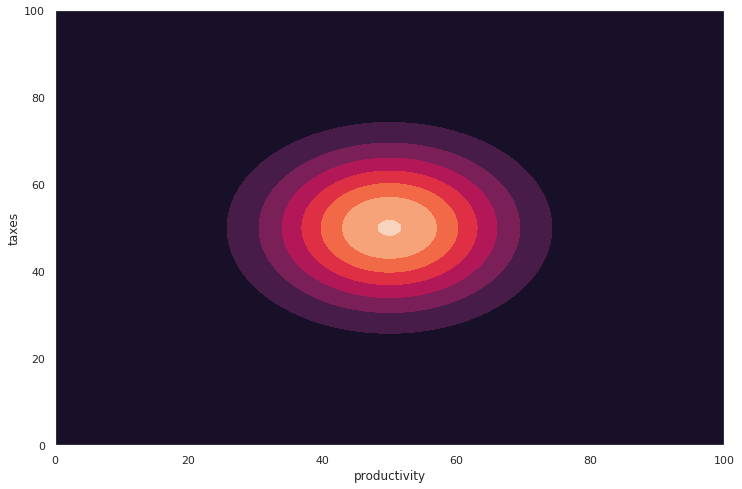

In [212]:
g = make_pdf(0)
_ = plot_dist(g)

### Parameters

In [137]:
params = {
    "beta": 0.99,
    "delta": 0.05,
    "alpha": 0.5,
    "gamma": 0.6, 
    "lambda": 0.1
}

params["rho"] = (1-params["beta"])/params["beta"] + params["delta"] 
M = 10_000

### Model

For more detail on the solution of the model check out the [original paper](https://www.sciencedirect.com/science/article/pii/S1094202508000203)

We assume a standard profit function with overhead labour costs,

In [149]:
fixed_overhead = 10_000
fixed_costs = 5*10e7

@np.vectorize
def optimal_factors(prod, tau, wage):
    net_prod = params["gamma"] - params["alpha"]
    den = 1-params["gamma"]
    
    k = np.power(params["alpha"]/params["rho"], (1-net_prod)/den) * np.power(net_prod/wage, net_prod/den)  * prod * np.power(100-tau, 1/den)
        
    l = np.power(prod*(100-tau)*net_prod/wage, 1/(1-net_prod))*np.power(k, params["alpha"]/(1-net_prod)) + fixed_overhead
        
    return k, l

@np.vectorize
def profit(prod, tau, wage):
    
    
    capital, labour = optimal_factors(prod, tau, wage)
    
    costs = wage*labour + params["rho"]*capital + fixed_costs
    
    pi = (100-tau)*prod*np.power(capital, params["alpha"])*np.power(labour-fixed_overhead, params["gamma"]-params["alpha"])
    
    
    return pi - costs

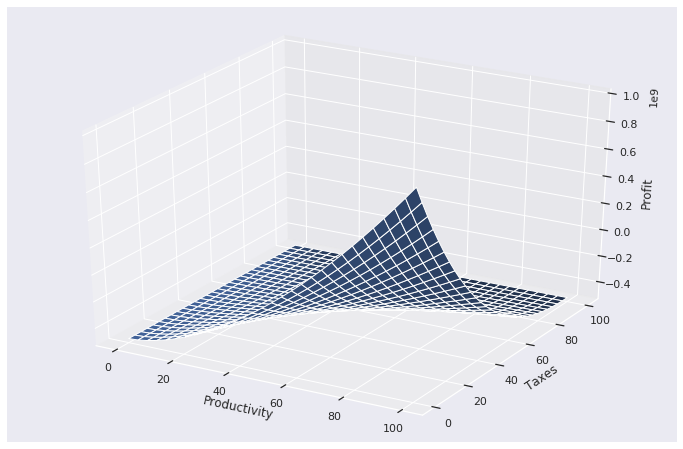

In [150]:
A, T = np.meshgrid(np.linspace(0, 100, 30), np.linspace(0.001, 100,  30))
pi = profit(A, T, 1)

ax = plt_3d(A, T, pi,
            labels=["Productivity", "Taxes", "Profit"])

### Entrants problem


In [151]:
from scipy.integrate import dblquad

In [156]:
@np.vectorize
def expected_payoff(prod, tau, wage):
    
    disc = 1 / (1-params["beta"])
    
    pi = profit(prod, tau, wage)*disc
        
    return max(pi, 0) - fixed_costs

def expected_revenue(wage, g):
    W_i = lambda a, t: expected_payoff(a, t, wage)*g([a, t])
    W, _ = dblquad(W_i, 0, 100, lambda x: 0, lambda x: 100)
    
    return W

In [157]:
expected_revenue(1, g)

-333111596.67414457

In [158]:
wages = np.linspace(0.001, 1, 20)

entrant_payoffs = []
for w in wages:
    print(f'{w}/1', end='\r')
    entrant_payoffs.append(expected_revenue(w, g))


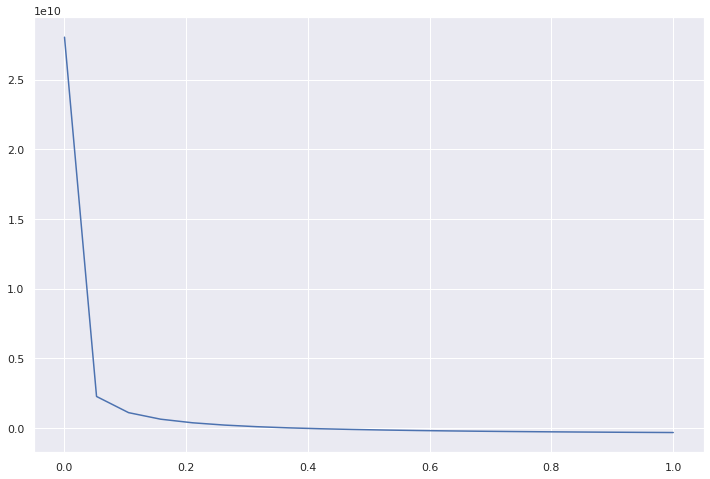

In [159]:
plt.plot(wages, entrant_payoffs)

### Stable distribution

In [160]:
def decision(wage):
    R = params["rho"] - params["delta"]
    disc = (1-params["lambda"])/(1-R)
    
    def x(tup):
        X, Y = tup[:, :, 0], tup[:, :, 1]
        pi = profit(X, Y, wage)*disc
        return np.where(pi > 0, 1, 0)
    
    return x

In [161]:
def firm_distribution(cov, wage):
    g = make_pdf(cov)
    x = decision(wage)
    
    def mu_hat(tup):
        decs = x(tup)
        dens = g(tup)
        
        return dens*decs*M
    
    return mu_hat

In [162]:
mu_hat = firm_distribution(0.15, 15)

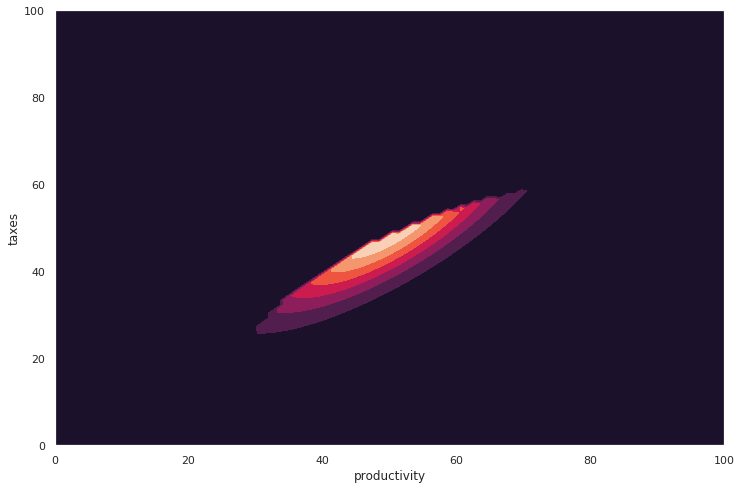

In [203]:
mu_hat = firm_distribution(120, 0.001)
_ = plot_dist(mu_hat)

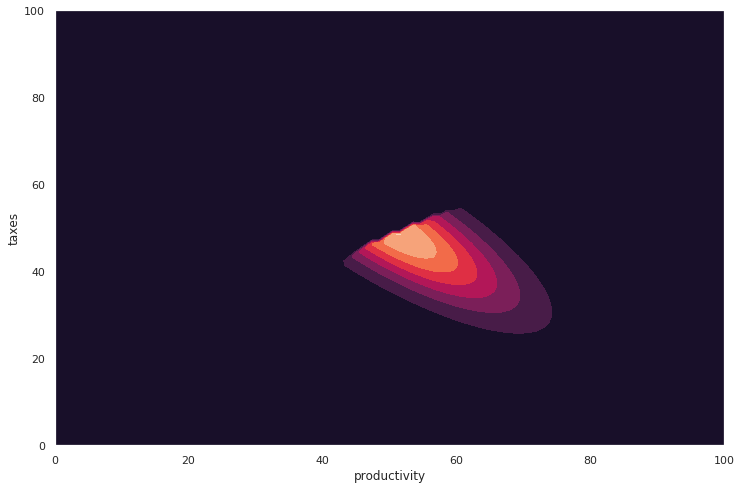

In [204]:
mu_hat = firm_distribution(-120, 0.001)
_ = plot_dist(mu_hat)

### Evolution

In [207]:
def plot_evol(cov, wage, iterations = 30, tau = 0.5,title=""):
    n = 150
    space = np.linspace(0, 100, n)
    X = decision(wage)
    
    x, y = np.meshgrid(space, tau)
    pos = np.dstack((x, y))

    g = make_pdf(cov)
    mu = np.ones(space.shape)/space.shape[0]
        
    for i in range(iterations):
        mu = (1-params["lambda"])*mu + X(pos)*g(pos)*M
        dist = mu.reshape(space.shape[0])
        a = 0.2+0.8*(i/iterations)
        plt.plot(space, dist, c='r', alpha=a)
        
    plt.title(title)
    plt.show()
    

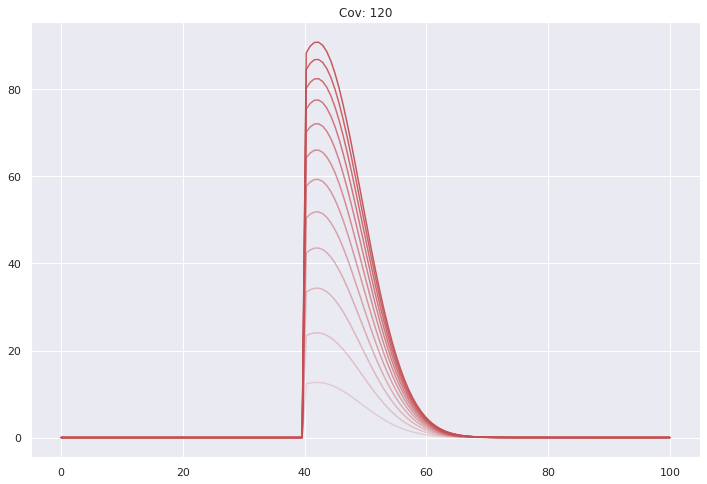

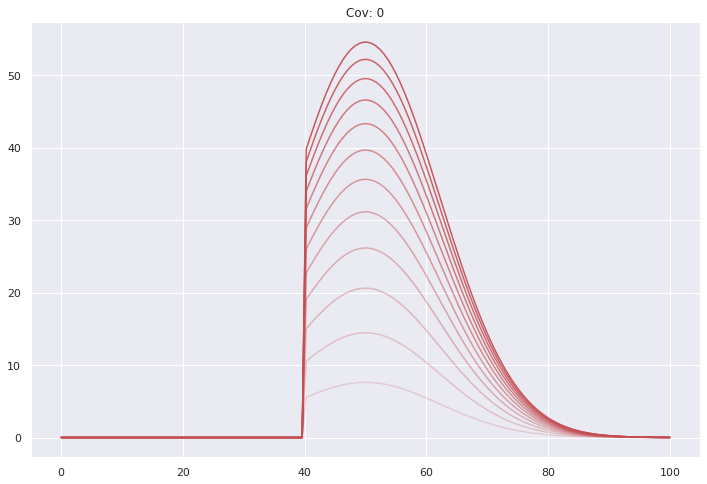

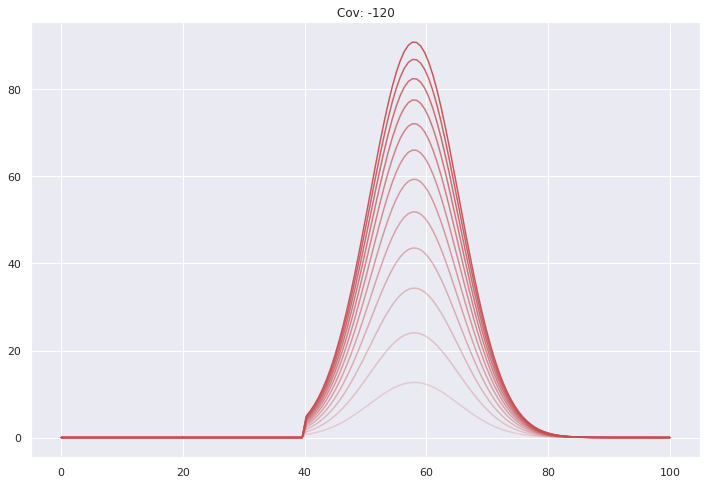

In [211]:
tau = 40
w = 0.001
cov = 120
plot_evol(cov, w, tau=tau, iterations=12, title=f"Cov: {cov}")
plot_evol(0, w, tau=tau, iterations=12, title=f"Cov: 0")
plot_evol(-cov, w, tau=tau, iterations=12, title=f"Cov: -{cov}")